In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Ajoute le dossier "src" au path
src_path = os.path.abspath("..")
if src_path not in sys.path:
    sys.path.append(src_path)
	
# NLP
import spacy

# Data manipulation
import numpy as np
import pandas as pd
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reducer
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.model_selection import train_test_split
import re
import emoji

# Models evalutations
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import importlib
from utils.result_helper import save_result
import utils.helper as helper 

/mnt/c/Users/steve/Desktop/ML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importation of the dataset

In [2]:
importlib.reload(helper)

nlp = helper.load_nlp_model()
config:helper.Step1Config = helper.ConfigLoader.load_step1()

df_path= "../../scitweets.tsv"
df_base = pd.read_csv(df_path, sep='\t', header=0)

df_base = df_base.drop(columns=[col for col in df_base.columns if "Unnamed" in col] + ["tweet_id"])
df_base["text"] = df_base["text"].astype(str)

## Preprocessing
1. On définit les préprocessings de la donnée

In [3]:
def emoji_processing(X: DataFrame) -> DataFrame:
	def count_emojis(text: str) -> int:
		return sum(1 for char in text if char in emoji.EMOJI_DATA)

	def replace_emojis(text: str) -> str:
		return emoji.demojize(text, delimiters=(" ", " "))
	
	X = X.copy()
	X["emoji_count"] = X["text"].apply(count_emojis)
	X["text"] = X["text"].apply(replace_emojis)
	return X
	
def link_processing(X: DataFrame) -> DataFrame:
	def count_links(text: str) -> int:
		return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

	def replace_link(text: str) -> str:
		return re.sub(r'https?:\/\/\S+', '[url]', text)
	
	X = X.copy()
	X["link_count"] = X["text"].apply(count_links)
	X["text"] = X["text"].apply(replace_link)
	return X

def hashtag_processing(X: DataFrame) -> DataFrame:
    def extract_hashtags(text: str) -> list:
        return re.findall(r'#(\w+)', text)
    
    def count_hashtags(text: str) -> int:
        return len(re.findall(r'#\w+', text))
    
    def replace_hashtags(text: str) -> str:
        return re.sub(r'#(\w+)', r'\1', text)
    
    X = X.copy()
    X["hashtag_count"] = X["text"].apply(count_hashtags)
    
	# On fait une listes de hashtags les plus utiliser 
    hashtags_series = X["text"].apply(extract_hashtags)
    hashtags_list = [tag for sublist in hashtags_series for tag in sublist]
    top_hashtags = pd.Series(hashtags_list).value_counts().head(20).index.tolist()
    
    for tag in top_hashtags:
        X[f"has_hashtag_{tag}"] = X["text"].apply(lambda x: 1 if f'#{tag}' in x.lower() else 0)
    
    X["text"] = X["text"].apply(replace_hashtags)
    
    return X

def number_processing(X: DataFrame) -> DataFrame:
    X = X.copy()
    X["numbers_count"] = X["text"].apply(lambda x: len(re.findall(r'\d+', x)))
    return X

def keyword_features(X: DataFrame) -> DataFrame:
    """D'après mon analyse de données, nous avons des mots très discriminants, j'en ai donc fait des features"""
    X = X.copy()
    
    science_keywords = ["study", "research", "health", "science", "cancer", "brain", "climate", "risk"]
    non_science_keywords = ["stop", "support", "reports", "please", "need", "today", "trump"]
    
    for word in science_keywords:
        X[f"has_sci_{word}"] = X["text"].apply(lambda x: 1 if re.search(r'\b' + word + r'\b', x.lower()) else 0)
    
    for word in non_science_keywords:
        X[f"has_nonsci_{word}"] = X["text"].apply(lambda x: 1 if re.search(r'\b' + word + r'\b', x.lower()) else 0)
    
    return X

def pre_processing(X: DataFrame) -> DataFrame:
	def preprocess(text):
		doc = nlp(text.lower())
		return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

	X = X.copy()
	X["text"] = X["text"].apply(preprocess)
	return X

2. On pre-processed le data
   
C'est très facile d'activer ou désactiver une feature

In [4]:
df = df_base.copy()
df = emoji_processing(df)
df = link_processing(df)
df = number_processing(df)
df = hashtag_processing(df)
df = keyword_features(df)
df = pre_processing(df)

In [5]:
X = df.copy().drop(columns=["scientific_claim", "scientific_reference", "scientific_context"])
y = X.pop("science_related")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.random_state, test_size=config.test_ratio)

X_train.head()

,text,emoji_count,link_count,numbers_count,hashtag_count,has_hashtag_EurekaMag,has_hashtag_COVID19,has_hashtag_jobs,has_hashtag_science,has_hashtag_ClimateChange,...,has_sci_brain,has_sci_climate,has_sci_risk,has_nonsci_stop,has_nonsci_support,has_nonsci_reports,has_nonsci_please,has_nonsci_need,has_nonsci_today,has_nonsci_trump
867,@drolufunmilayo smoking cannabis help control ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
831,kid wear sunglass support classmate battle eye...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1057,@csrv @jay4profit thank yes reaction lead big ...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1118,kaiser stop lurk useless expect tribute 10 min...,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
654,$ imgn immunogen report recent progress quarte...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Evaluation des classifiers sans tunning avec TF-IDF & Bag of words

On va utiliser une classe python, qui va essayer a tour de role, les classifiers sans tuning des paramètres, d'abord avec une vectorisation TF-IDF puis avec Bag of words

In [12]:
import classification_2classe.evaluation_classifiers as evaluation_classifiers
importlib.reload(evaluation_classifiers)

evaluator = evaluation_classifiers.ClassifierEvaluation(X_train, y_train, X_test, y_test)
results, sorted_results = evaluator.evaluate()

 
=== CLASSEMENT DES MODÈLES (par F1-score) ===
ℹ️  1. Naive Bayes avec Bag of words
   F1-score: 0.7705 ± 0.0328
   Accuracy: 0.8004 ± 0.0294
ℹ️  2. Random Forest avec Bag of words
   F1-score: 0.7663 ± 0.0165
   Accuracy: 0.7993 ± 0.0149
ℹ️  3. Naive Bayes avec TF-IDF
   F1-score: 0.7594 ± 0.0368
   Accuracy: 0.8070 ± 0.0275
ℹ️  4. Régression Logistique avec TF-IDF
   F1-score: 0.7561 ± 0.0160
   Accuracy: 0.8070 ± 0.0120
ℹ️  5. Régression Logistique avec Bag of words
   F1-score: 0.7490 ± 0.0385
   Accuracy: 0.7983 ± 0.0282
ℹ️  6. SVM Linéaire avec TF-IDF
   F1-score: 0.7425 ± 0.0260
   Accuracy: 0.7840 ± 0.0205
ℹ️  7. Random Forest avec TF-IDF
   F1-score: 0.7373 ± 0.0450
   Accuracy: 0.8038 ± 0.0285
ℹ️  8. SVM Linéaire avec Bag of words
   F1-score: 0.7260 ± 0.0183
   Accuracy: 0.7654 ± 0.0115
ℹ️  9. Decision Tree avec Bag of words
   F1-score: 0.7194 ± 0.0247
   Accuracy: 0.7588 ± 0.0244
ℹ️  10. KNN avec TF-IDF
   F1-score: 0.7054 ± 0.0336
   Accuracy: 0.7511 ± 0.0295
ℹ️  11. Dec

# Selections des 3 models a Tuning

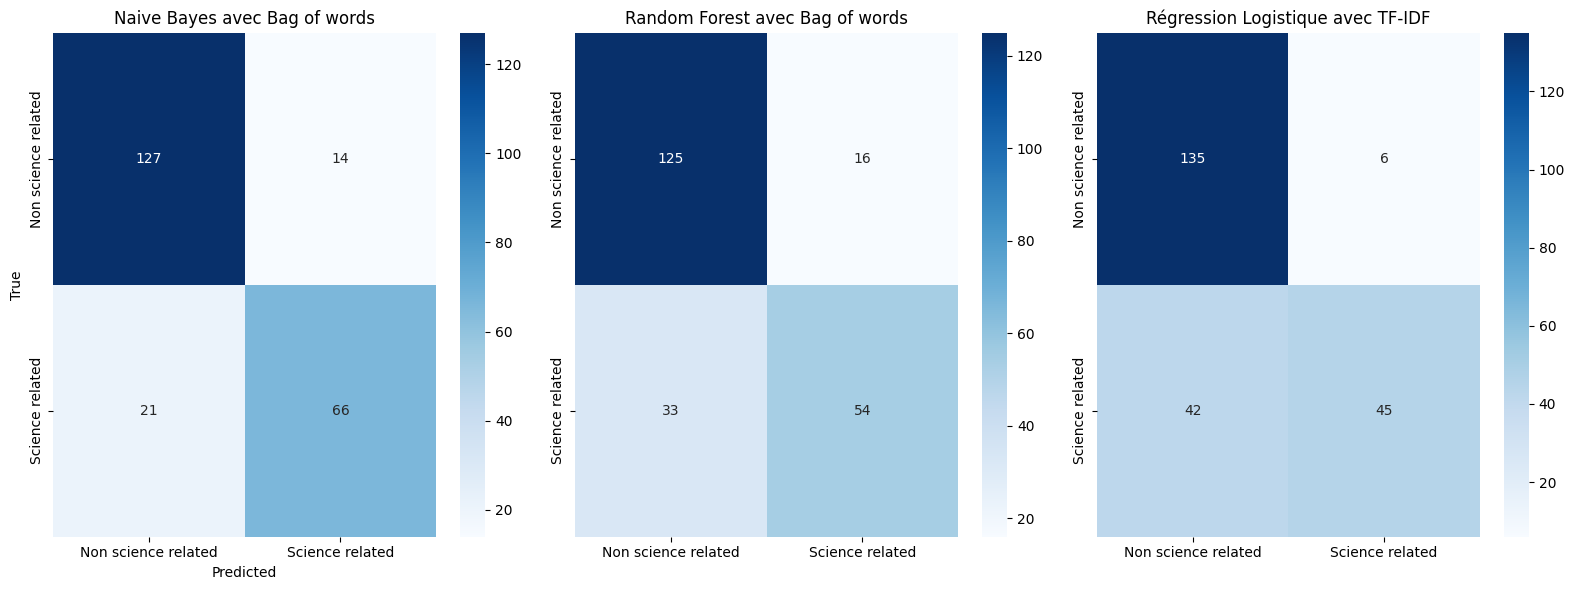

In [29]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.heatmap(results["Naive Bayes_Bag of words"]['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=["Non science related", "Science related"],
			yticklabels=["Non science related", "Science related"])
plt.title("Naive Bayes avec Bag of words")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.subplot(1, 3, 2)
sns.heatmap(results["Random Forest_Bag of words"]['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=["Non science related", "Science related"],
			yticklabels=["Non science related", "Science related"])
plt.title("Random Forest avec Bag of words")
plt.subplot(1, 3, 3)
sns.heatmap(results["Régression Logistique_TF-IDF"]['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=["Non science related", "Science related"],
			yticklabels=["Non science related", "Science related"])
plt.title("Régression Logistique avec TF-IDF")

plt.tight_layout()
plt.show()

# Visualisation PCA

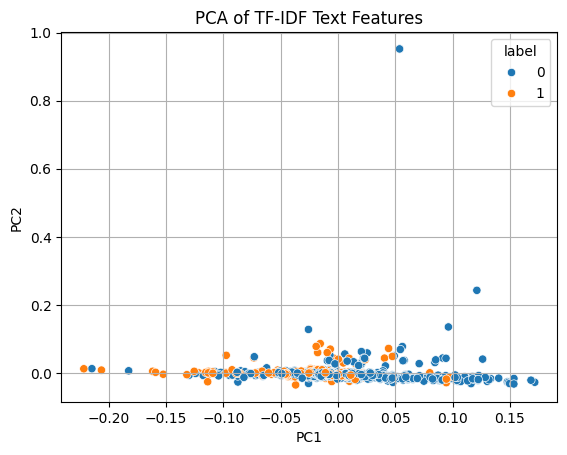

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'label': y_train.values
})

sns.scatterplot(data=df, x='PC1', y='PC2', hue='label')
plt.title("PCA of TF-IDF Text Features")
plt.grid(True)
plt.show()


In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Ajoute le dossier "src" au path
src_path = os.path.abspath("..")
if src_path not in sys.path:
    sys.path.append(src_path)
	
# NLP
import spacy

# Data manipulation
import numpy as np
import pandas as pd
from pandas import DataFrame

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Reducer
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.model_selection import train_test_split
import re
import emoji

# Models evalutations
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import importlib
from utils.result_helper import save_result
import utils.helper as helper 

/mnt/c/Users/steve/Desktop/ML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
